In [1]:
import discretize
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

import BTInvert
import uxo_utils

import polarizability_model as pm

from matplotlib import rcParams
rcParams["font.size"] = 14

In [2]:
sensorinfo = uxo_utils.load_sensor_info("UltraTEM")
ordnance = uxo_utils.load_ordnance_dict()
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

In [3]:
times = ordnance["ISO Small"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [4]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.2,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=0.28,
    pitch=0,
    roll=0,
    yaw=0,
)

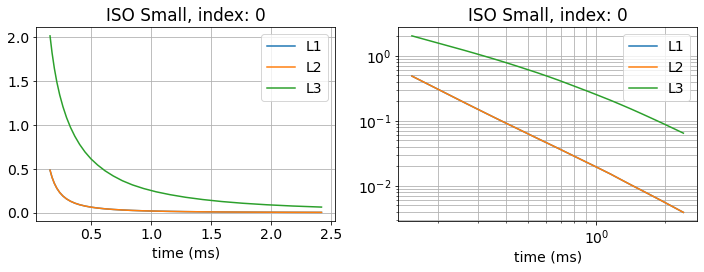

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
key = "ISO Small"
i = 0
for l in ["L1", "L2", "L3"]:
    L = ordnance[key][l][i]
    ax[0].plot(times, L, label=l)
    ax[1].loglog(times, L, label=l)

for a in ax:
    a.set_title(f"{key}, index: {i}")
    a.grid(which="both")
    a.legend()
    a.set_xlabel("time (ms)")
    # a.set_ylim([1e-3, 20])
        
plt.tight_layout()

In [6]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, times, 
    survey_dict["mnum"], survey_dict["pos"], 
    survey_dict["pitch"], survey_dict["roll"], survey_dict["yaw"]
)

In [7]:
key = "ISO Small"
ind = 0
ord_loc = np.r_[0, 0, -0.25]
ord_ypr = np.r_[0, 0, 0]

L3, L2, L1 = (ordnance[key][l][ind] for l in ["L1", "L2", "L3"])

data_uxo = uxo_utils.simulate_object(
    L1, L2, L3, fwd_params, times, ord_loc, ord_ypr
)



In [8]:
mod = BTInvert.Model(xyz=ord_loc, gba=ord_ypr, l3=L3, l2=L2, l1=L1, times=times)

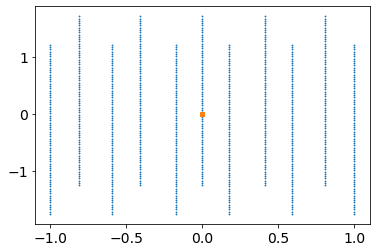

In [9]:
plt.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.', alpha=0.8, ms=1)
plt.plot(ord_loc[0], ord_loc[1], 's', ms=4)

In [10]:
sensor_table = sensorinfo.measNum2TxRxRxcCube()
# sensor_table = sensor_table[mnum, :]

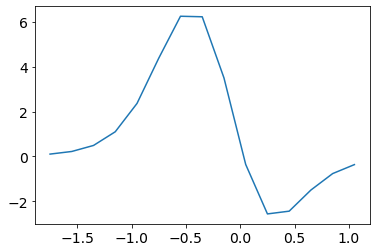

In [11]:
mnum_plot = 11
fig, ax = plt.subplots(1, 1)
ax.plot(
    survey_dict["pos"][survey_dict["mnum"] == mnum_plot, 1], 
    data_uxo[mnum_plot, :, 0]
)

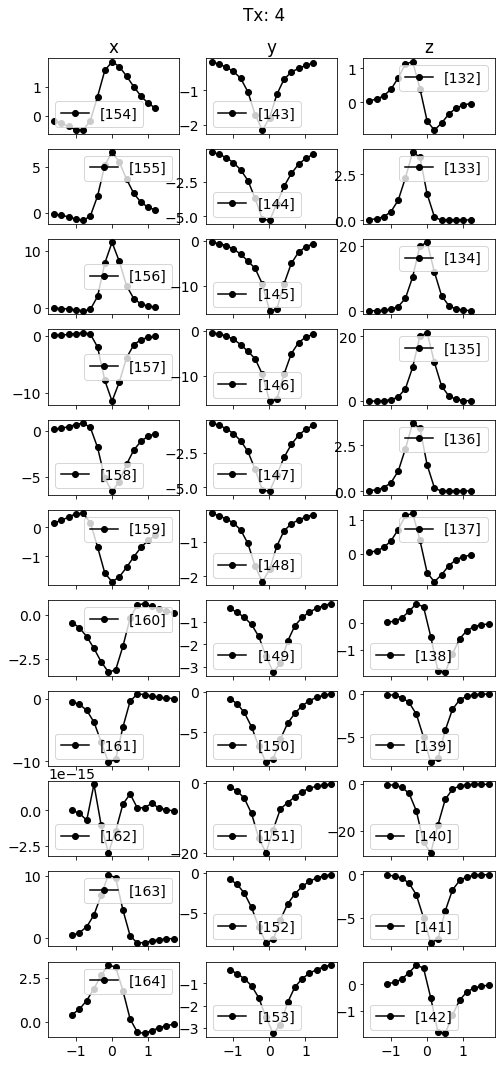

In [12]:
txind = 4  # transmitter
tind = 0  # time
fig, ax = plt.subplots(11, 3, figsize=(8, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (sensor_table[:, 0] == txind) & (sensor_table[:, 3]==i)
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        mnum_plot = np.where(rx_plot & (sensor_table[:, 2] == j))[0]
        y_plot = survey_dict["pos"][survey_dict["mnum"] == mnum_plot, 1]
        ax[i, j].plot(y_plot, data_uxo[mnum_plot, :, tind].squeeze(), "-o", color="k", label=mnum_plot)
        ax[i, j].legend()


In [13]:
# loop over transmitters
src_list = []
nrx = sensor_table[:, 3].max() + 1
ncomponents = sensor_table[:, 2].max() + 1
ndata = nrx*ncomponents

for i, txi in enumerate(survey_dict["txnum"]): 
    
    # reorder transmitter nodes so we are always doing right handed integrations
    tx = sensorinfo.transmitters[txi]
    tx_corners = np.vstack([tx.shape[i, :] for i in [2, 1, 0, 3, 2]])
    tx_corners = tx_corners + survey_dict["xyz"][i, :]

    receiver_inds = slice(i*ndata,i*ndata + nrx)

    receivers = pm.MagneticFluxDensityReceiver(
        survey_dict["pos"][receiver_inds, :], 
        components=["z", "y", "x"]
    )
    src = pm.MagneticControlledSource(receiver_list=[receivers], location=tx_corners, current=1)
    src_list.append(src)

In [14]:
survey = pm.Survey(src_list)
survey.nD

2475

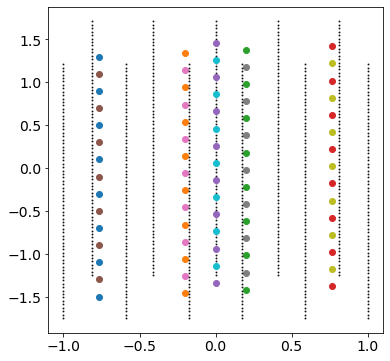

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# mesh.plot_grid(ax=ax, linewidth=1)

for src in survey.source_list: 
    rx_locs = src.receiver_list[0].locations
    ax.plot(
        (src.location[:, 0].min() + src.location[:, 0].max())/2.,
        (src.location[:, 1].min() + src.location[:, 1].max())/2.,
        "o"
    )
    ax.plot(rx_locs[:, 0], rx_locs[:, 1], '.k', alpha=0.8, ms=2)
    # ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

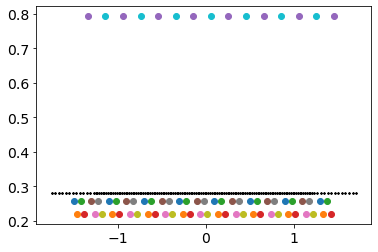

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# mesh.plot_grid(ax=ax, linewidth=1)

for src in survey.source_list: 
    rx_locs = src.receiver_list[0].locations
    ax.plot(
        (src.location[:, 1].min() + src.location[:, 1].max())/2.,
        (src.location[:, 2].min() + src.location[:, 2].max())/2.,
        "o"
    )
    ax.plot(rx_locs[:, 1], rx_locs[:, 2], '.k', alpha=0.8, ms=2)
    # ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

In [17]:
core_domain = 2 # meters
nc = 32
dx = core_domain/nc
npad = 4
pf = 1.5
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")
mesh.n_cells

1600

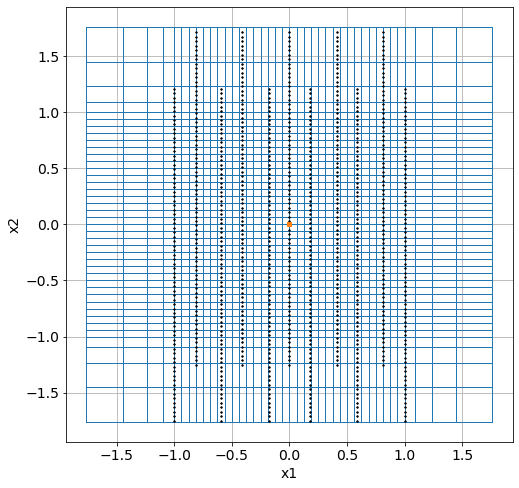

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

mesh.plot_grid(ax=ax, linewidth=1)
ax.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.k', alpha=0.8, ms=2)
ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

In [19]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])

In [20]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [21]:
rxi = 0
txi = 0 
[np.where(
    (sensor_table[:, 2] == c) & 
    (sensor_table[:, 3] == rxi) & 
    (sensor_table[:, 0] == txi)
)[0] for c in range(3)]

[array([22]), array([11]), array([0])]

In [22]:
ntx = int(survey_dict["txnum"].max()) + 1

def reorder_mnum(sensor_table):
    return np.hstack([
        np.hstack([
                np.where(
                    (sensor_table[:, 3] == rxi) & 
                    (sensor_table[:, 0] == txi)
                )[0] for rxi in range(nrx)
        ]) for txi in range(ntx)
    ])

In [23]:
mnum_reordered = reorder_mnum(sensor_table)

ncycles = int(len(survey_dict["mnum"])/len(mnum_reordered))
mnum_reordered_full = np.hstack([mnum_reordered]*ncycles)
sensor_table_reordered_full = sensor_table[mnum_reordered_full, :]

expanded_reorder = np.hstack([mnum_reordered + len(mnum_reordered)*i for i in range(ncycles)])

In [24]:
mnum_reordered

array([  0,  11,  22,   1,  12,  23,   2,  13,  24,   3,  14,  25,   4,
        15,  26,   5,  16,  27,   6,  17,  28,   7,  18,  29,   8,  19,
        30,   9,  20,  31,  10,  21,  32,  33,  44,  55,  34,  45,  56,
        35,  46,  57,  36,  47,  58,  37,  48,  59,  38,  49,  60,  39,
        50,  61,  40,  51,  62,  41,  52,  63,  42,  53,  64,  43,  54,
        65,  66,  77,  88,  67,  78,  89,  68,  79,  90,  69,  80,  91,
        70,  81,  92,  71,  82,  93,  72,  83,  94,  73,  84,  95,  74,
        85,  96,  75,  86,  97,  76,  87,  98,  99, 110, 121, 100, 111,
       122, 101, 112, 123, 102, 113, 124, 103, 114, 125, 104, 115, 126,
       105, 116, 127, 106, 117, 128, 107, 118, 129, 108, 119, 130, 109,
       120, 131, 132, 143, 154, 133, 144, 155, 134, 145, 156, 135, 146,
       157, 136, 147, 158, 137, 148, 159, 138, 149, 160, 139, 150, 161,
       140, 151, 162, 141, 152, 163, 142, 153, 164])

In [25]:
np.all(sensor_table_reordered_full == sensor_table[survey_dict["mnum"]][expanded_reorder, :])

True

In [26]:
pos_reordered = survey_dict["pos"][expanded_reorder, :]

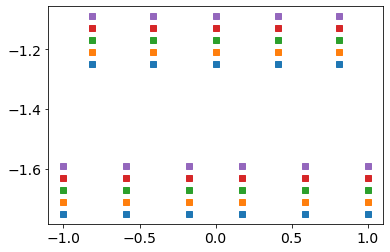

In [27]:
fig, ax = plt.subplots(1, 1)
for src in src_list[:5]:
    rx = src.receiver_list[0]
    ax.plot(rx.locations[:, 0], rx.locations[:, 1], "s")

In [28]:
mtest = np.zeros_like(locations)

x_target = np.r_[-0.125, 0.125]
y_target = np.r_[-0.125, 0.125]
m_target = np.r_[0.1, 0.1, 1]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtest[bounding_box, i] = m

mtest = mtest.flatten() #discretize.utils.mkvc(mtrue)

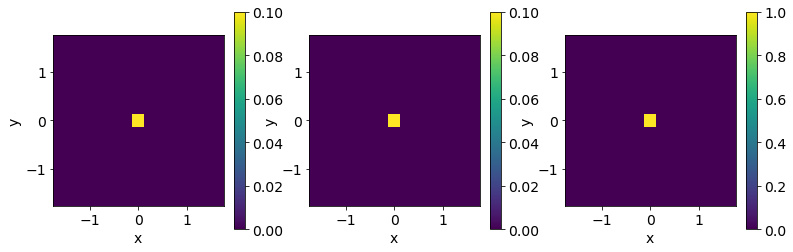

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mtest[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [30]:
dpred_test = sim.dpred(mtest)

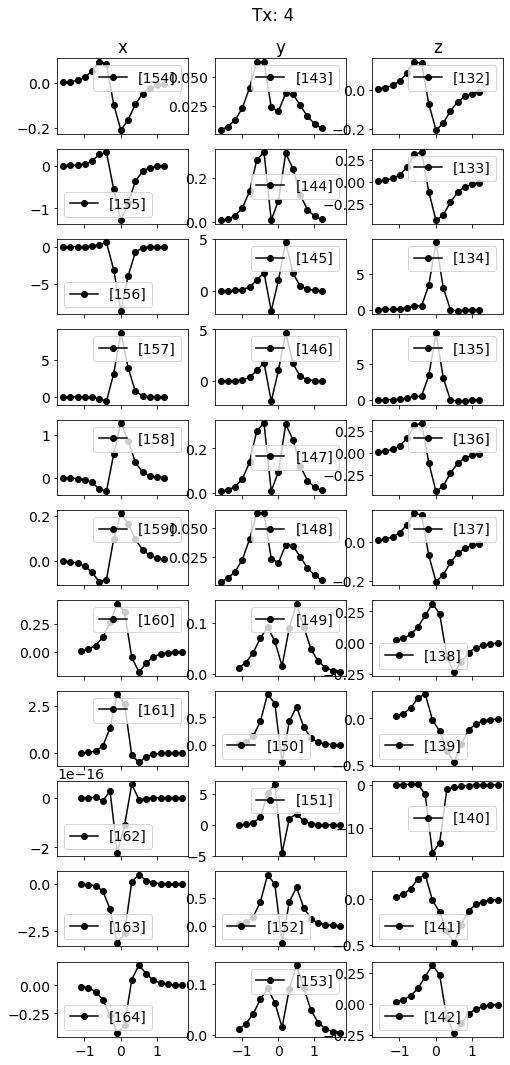

In [31]:
txind = 4 # transmitter
tind = 0  # time
fig, ax = plt.subplots(11, 3, figsize=(8, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (
        (sensor_table_reordered_full[:, 0] == txind) & 
        (sensor_table_reordered_full[:, 3] == i)
    )
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

        y_plot = pos_reordered[inds_plot, 1]
        d_plot = dpred_test[inds_plot]
        ax[i, j].plot(y_plot, d_plot, "-o", color="k", label=np.unique(mnum_reordered_full[inds_plot]))
        ax[i, j].legend()


In [32]:
noise_floor = 0.1*np.max(np.abs(dpred_test))
inversion_test = pm.Inversion(sim, dpred_test, noise_floor, beta=None)

In [33]:
mrec_test = inversion_test.solve(beta_fact=1)

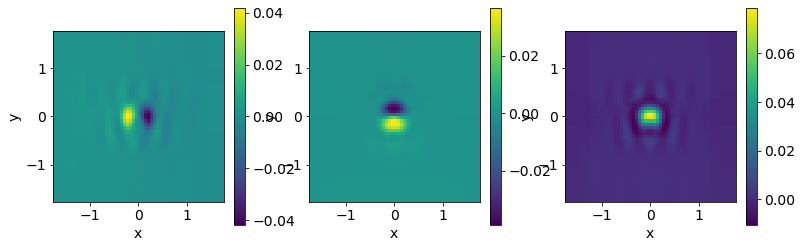

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [35]:
dpred_mrec_test = sim.dpred(mrec_test)

In [36]:
from SimPEG import data_misfit, regularization, optimization, inverse_problem, inversion, directives, Data

In [37]:
dmis_test = data_misfit.L2DataMisfit(
    data=Data(survey, dobs=dpred_test, noise_floor=0.1*np.max(np.abs(dpred_test))), simulation=sim
)
# wires = maps.Wires(("x", mesh.nC), ("y", mesh.nC), ("z", mesh.nC))
nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg_test = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [38]:
opt_test = optimization.ProjectedGNCG(maxIterCG=60, stepOffBoundsFact=1e-8, lower=0, maxIter=20) 
invprob_test = inverse_problem.BaseInvProblem(dmis_test, reg_test, opt_test) 

In [39]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [40]:
inv_test = inversion.BaseInversion(invprob_test, directive_list)

In [41]:
mrec_test_pos = inv_test.run(np.zeros(mesh.nC * 3)+1e-8)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.21e+02  3.08e+02  2.40e-13  3.08e+02    2.28e+02      0              


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.0855e+01
0 : |xc-x_last| = 1.0655e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.2790e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.2790e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      1
------------------------- DONE! -------------------------


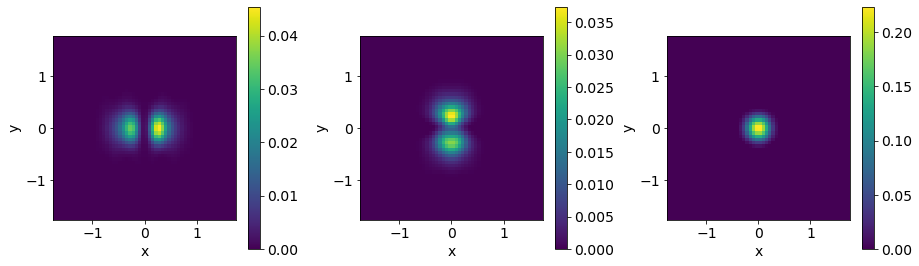

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test_pos[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)
    # a.set_xlim([-1, 1])
    # a.set_ylim([-1, 1])
plt.tight_layout()

In [43]:
dpred_mrec_test_pos = sim.dpred(mrec_test_pos)

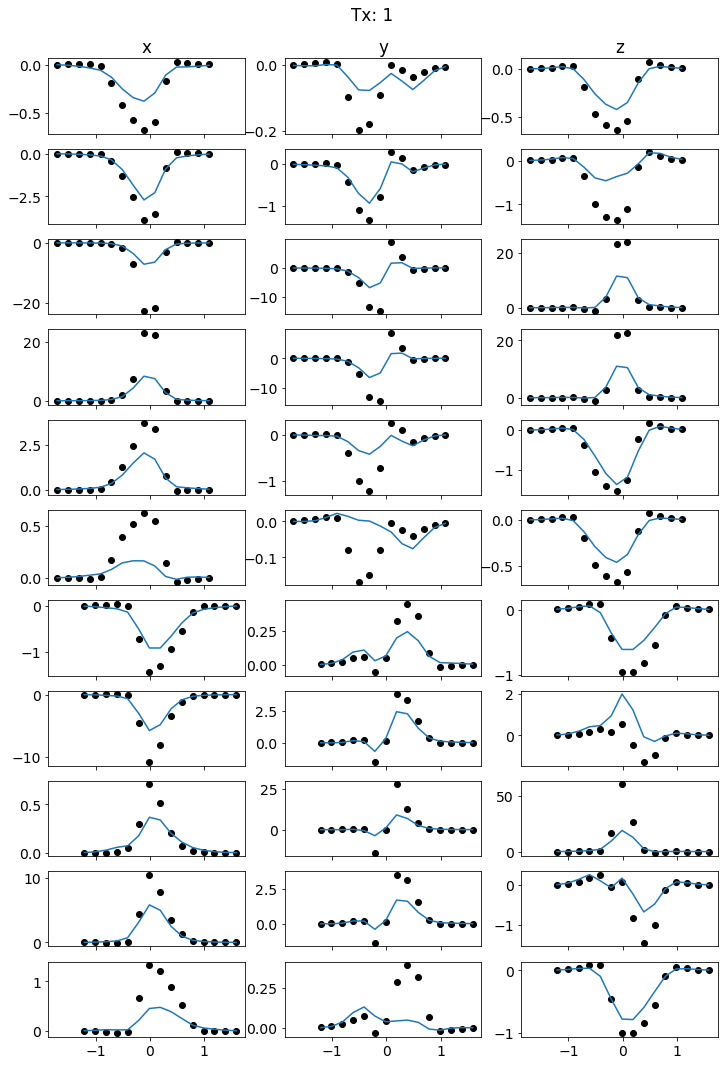

In [44]:
txind = 1 # transmitter
fig, ax = plt.subplots(11, 3, figsize=(12, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (
        (sensor_table_reordered_full[:, 0] == txind) & 
        (sensor_table_reordered_full[:, 3] == i)
    )
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

        y_plot = pos_reordered[inds_plot, 1]
        d_plot = dpred_test[inds_plot]
        d_plot_pred = dpred_mrec_test_pos[inds_plot]
        ax[i, j].plot(y_plot, d_plot, "o", color="k", label="obs")
        ax[i, j].plot(y_plot, d_plot_pred, "-", color="C0", label="pred")
        # ax[i, j].legend()


## Now with UXO simulation 

In [45]:
# find x, y indices
mnum_xy = (sensor_table[:, 2] != 2)

In [46]:
# reorder so it is by reciever cube and then location
# NOTE: for multiple lines with different yaw, we will need to rotate data
tind_invert = 0
data_uxo_rotated = data_uxo.copy()

d_invert = data_uxo[:, :, tind_invert]
d_invert[mnum_xy, :] = d_invert[mnum_xy, :] * -1
d_invert = d_invert[mnum_reordered, :].flatten(order="F")

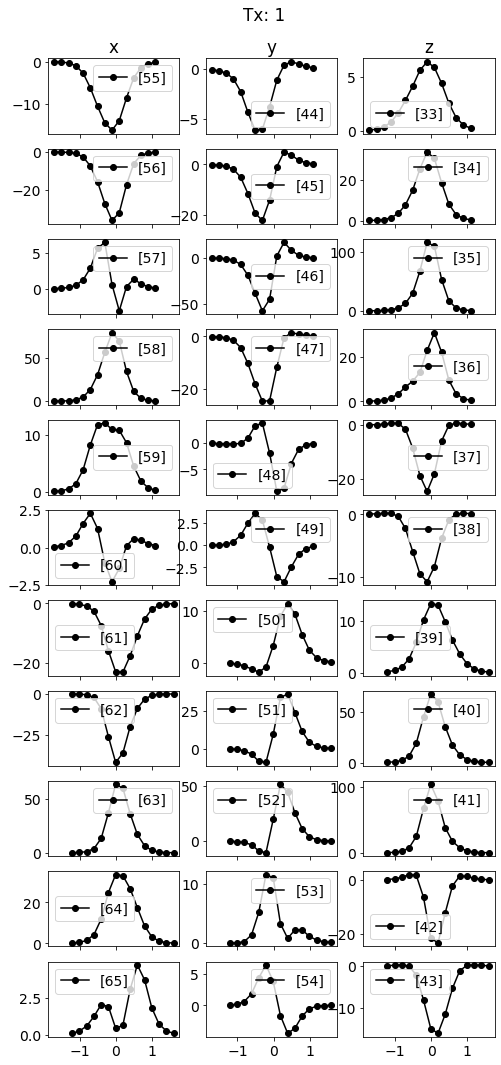

In [47]:
txind = 1 # transmitter
fig, ax = plt.subplots(11, 3, figsize=(8, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (
        (sensor_table_reordered_full[:, 0] == txind) & 
        (sensor_table_reordered_full[:, 3] == i)
    )
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

        y_plot = pos_reordered[inds_plot, 1]
        d_plot = d_invert[inds_plot]
        ax[i, j].plot(y_plot, d_plot, "-o", color="k", label=np.unique(mnum_reordered_full[inds_plot]))
        ax[i, j].legend()


In [48]:
sim = pm.SimulationPolarizabilityModel(locations, survey, mapping=maps.IdentityMap(nP=3*mesh.nC))

In [49]:
noise = 0.05*np.max(np.abs(d_invert)) 
inversion_uxo = pm.Inversion(sim, d_invert, noise, beta=None)

In [ ]:
mrec0 = inversion_uxo.solve(beta_fact=1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec0[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [ ]:
survey.nD

In [ ]:
dpred_mrec0 = sim.dpred(mrec0)

## Now with simpeg

In [ ]:
0.05*np.abs(d_invert).max()

In [ ]:
dmis = data_misfit.L2DataMisfit(
    data=Data(
        survey, dobs=d_invert, 
        noise_floor=0.05*np.abs(d_invert).max(), 
        # relative_error=0.1
    ), 
    simulation=sim
)

nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [ ]:
opt = optimization.ProjectedGNCG(maxIterCG=60, stepOffBoundsFact=1e-10, lower=0, maxIter=20) 
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 

In [ ]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=1), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [ ]:
inv = inversion.BaseInversion(invprob, directive_list)

In [ ]:
mrec = inv.run(np.zeros(mesh.nC * 3)+1e-8)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec[i::3], ax=a)[0], ax=a)
    # a.set_xlim([-1, 1])
    # a.set_ylim([-1, 1])
    a.set_aspect(1)
    

In [ ]:
txind = 1 # transmitter
fig, ax = plt.subplots(11, 3, figsize=(12, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (
        (sensor_table_reordered_full[:, 0] == txind) & 
        (sensor_table_reordered_full[:, 3] == i)
    )
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

        y_plot = pos_reordered[inds_plot, 1]
        d_plot = d_invert[inds_plot]
        d_plot_pred = invprob.dpred[inds_plot]
        ax[i, j].plot(y_plot, d_plot, "o", color="k", label="obs")
        ax[i, j].plot(y_plot, d_plot_pred, "-", color="C0", label="pred")
        # ax[i, j].legend()
